In [2]:
#############################################################------MODELISATION 2-----####################################################################################################
#                                                                    
#                                                       Modelisation sur le jeu de données 
#                                               avec l'intégration de 2 nouvelles caracteristiques NLP  :
#                                                       - Negation dans le titre du commentaire 
#                                                       - Classification de sentiments avec BERT      
#                                                               
#                                                              
#############################################################################################################################################################################################



################################################ - IMPORTATION des bibliotheques - ##################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import ClusterCentroid
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap




################################################## - RECUPERATION de la base projet csv - ##################################

df_base_apres_processing = pd.read_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\df2.projet_truspilot2_etape3.csv", sep=',')
display(df_base_apres_processing.head())
df_base_apres_processing.info()

df=df_base_apres_processing.drop(["mots","mots_titre","Nombre_Émoticônes_Positives","Nombre_Émoticônes_Négatives"],axis=1)


c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Nombre_avis_client,Note_client,Titre_commentaire,Commentaire,mots,mots_titre,Lemmes,Lemmes_titre_commentaire,class_note,class_nbavis,nbre_mots,nbre_phrases,class_longueur_mot,class_pt_exclam,Nombre_Émoticônes_Positives,Nombre_Émoticônes_Négatives,class_sentiment,emoticones,sentimentfr,Nombre_Émoticônes
0,6,5,très bon support technique,"bonjour, j'ai acheté ma première configurztion...","['bonjour', ',', ""j'ai"", 'acheté', 'ma', 'prem...","['très', 'bon', 'support', 'technique']","['acheté', 'premi', 'configurztion', 'chez', '...","['support', 'technique']",satisfait,4-123,66,2,long,E0,0,0,Positif,Neutre,0.176000,0
1,2,5,site clair et infos constructives,je partais à la recherche de mon premier ecran...,"['je', 'partais', 'à', 'la', 'recherche', 'de'...","['site', 'clair', 'et', 'infos', 'constructives']","['partais', 'recherche', 'premier', 'ecran', '...","['site', 'clair', 'infos', 'info', 'constructi...",satisfait,2-3,58,3,long,E1,0,0,Positif,Neutre,0.197813,0
2,2,5,j'ai récemment eu un problème avec ma…,j'ai récemment eu un problème avec ma carte gr...,"[""j'ai"", 'récemment', 'eu', 'un', 'problème', ...","[""j'ai"", 'récemment', 'eu', 'un', 'problème', ...","['récemment', 'probl', 'carte', 'graphique', '...","['récemment', 'probl']",satisfait,2-3,45,3,long,E0,0,0,Neutre,Neutre,0.000000,0
3,2,5,ras comme toujours,je passe par materiel.net car historiquement j...,"['je', 'passe', 'par', 'materiel.net', 'car', ...","['ras', 'comme', 'toujours']","['passe', 'materiel', 'historiquement', 'sais'...","['comme', 'toujours']",satisfait,2-3,77,2,long,E0,0,0,Positif,Neutre,0.087500,0
4,1,5,cela fait des années que j'achète sur…,cela fait des années que j'achète sur votre si...,"['cela', 'fait', 'des', 'années', 'que', ""j'ac...","['cela', 'fait', 'des', 'années', 'que', ""j'ac...","['années', 'site', 'matériel', 'seule', 'fois'...",['années'],satisfait,1,49,3,long,E0,0,0,Positif,Neutre,0.284000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33563 entries, 0 to 33562
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Nombre_avis_client           33563 non-null  int64  
 1   Note_client                  33563 non-null  int64  
 2   Titre_commentaire            33563 non-null  object 
 3   Commentaire                  33563 non-null  object 
 4   mots                         33563 non-null  object 
 5   mots_titre                   33563 non-null  object 
 6   Lemmes                       33563 non-null  object 
 7   Lemmes_titre_commentaire     33563 non-null  object 
 8   class_note                   33563 non-null  object 
 9   class_nbavis                 33563 non-null  object 
 10  nbre_mots                    33563 non-null  int64  
 11  nbre_phrases                 33563 non-null  int64  
 12  class_longueur_mot           33562 non-null  object 
 13  class_pt_exclam 

In [ ]:
 
############################################## - CREATION DES 2 nouvelles VARIABLES- #############################################################
##################################################################################################################################################


#____________________________________________________________________________________________________________________________________________________#
#                                                       
#                                                          Création "NBNEG" 
#                                        Nombre d’élèments de négation dans le titre du commentaire
#                                     
#_____________________________________________________________________________________________________________________________________________________#



def custom_tokenize(text):
    # Compteur pour les négations
    negation_count = 0
    
    # Remplace les formes de négation par un symbole spécial et compte les occurrences
    def count_negation(match):
        nonlocal negation_count
        negation_count += 1
        return f'NEGATION_{match.group(1)}'
    
    # Mise à jour de l'expression régulière pour inclure "non"
    text = re.sub(r'\b(ne|n\'|pas|jamais|plus|non)\b', count_negation, text)
    
    # Tokenisation 
    tokens1 = re.findall(r'\b\w+\b|NEGATION\w+', text)
    
    # Remplace le symbole spécial par le mot de négation
    tokensneg = [token.replace("NEGATION_", "") for token in tokens1]
    
    return tokens1, negation_count

# Applique la fonction à chaque ligne du DataFrame
def process_row(row):
    combined_text =  row['Titre_commentaire']

    tokens, negation_count = custom_tokenize(combined_text)
    
    # Détermine si le texte est négatif
    negatif = 1 if negation_count > 0 else 0  #negatif = oui=1
    
    return pd.Series([negatif, negation_count])

# Applique la fonction process_row à chaque ligne et créer de nouvelles colonnes
df[['negatif', 'nbneg']] = df.apply(process_row, axis=1)

# Affiche le DataFrame modifié
#display(df.head())


#____________________________________________________________________________________________________________________________________________________#
#                                                       
#                                                          Création "SENTIMENT_DL" 
#                                       modèle BERT ("nlptown/bert-base-multilingual-uncased-sentiment")
#                                     Chaque commentaire, associé à son titre, est classé de 1 à 5 par ce modèle 
#_____________________________________________________________________________________________________________________________________________________#


# Étape 1 : Chargement du modèle et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# modèle en mode évaluation
model.eval()

# Étape 2 : Fonction pour prédire le sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():  # Pas besoin de calculer les gradients
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()  # Obtenir l'indice de la classe avec la plus haute probabilité
    return sentiment+1    #modifier les classes de 1 à 5

# Étape 3 : Applique la fonction à chaque ligne du DataFrame
def process_row(row):
    combined_text = row['Commentaire'] + " " + row['Titre_commentaire']
    return predict_sentiment(combined_text)


df['sentiment_dl'] = df.apply(process_row, axis=1)

#display(df)

#############################################################- Sauvegarde une nouvelle base pour éviter de refaire tourner les varaible NLP -###################################
 
#df.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\derniere_base.csv", sep=';', index=False)

                    Nombre_avis_client  Note_client  nbre_mots  nbre_phrases  \
Nombre_avis_client            1.000000     0.033184   0.027012      0.024082   
Note_client                   0.033184     1.000000  -0.452543     -0.315242   
nbre_mots                     0.027012    -0.452543   1.000000      0.699206   
nbre_phrases                  0.024082    -0.315242   0.699206      1.000000   
sentimentfr                  -0.000870     0.387454  -0.236993     -0.139834   
Nombre_Émoticônes            -0.002015     0.004003   0.026240      0.035355   
negatif                      -0.004575    -0.287056   0.112069      0.068262   
nbneg                        -0.006388    -0.293876   0.125270      0.079210   
sentiment_dl                  0.021500     0.835704  -0.446124     -0.297346   

                    sentimentfr  Nombre_Émoticônes   negatif     nbneg  \
Nombre_avis_client    -0.000870          -0.002015 -0.004575 -0.006388   
Note_client            0.387454           0.004003 

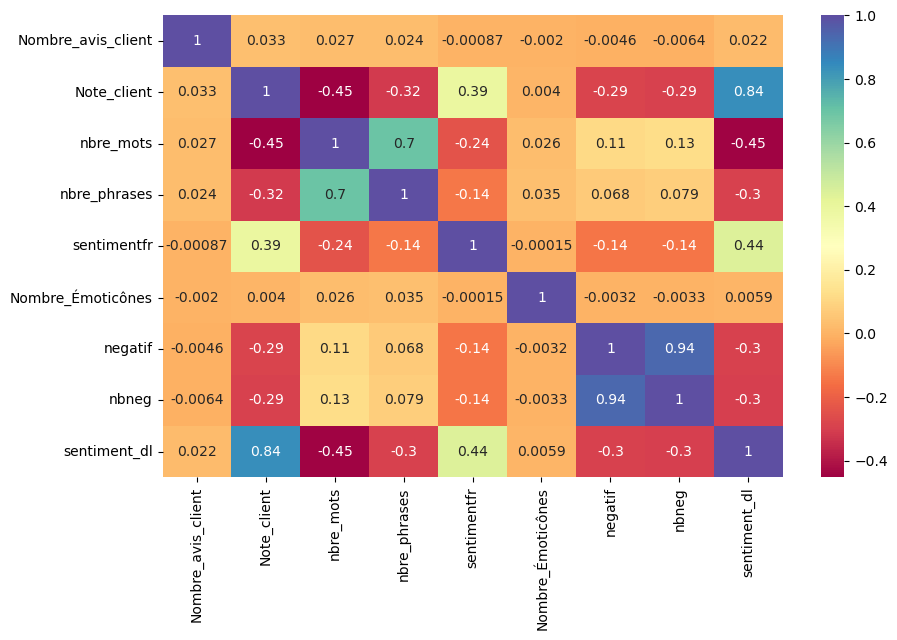

In [3]:
#df.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\nouvelle_base_3classes.csv", sep=';', index=False, encoding='utf-8-sig')
#df=pd.read_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\nouvelle_base_3classes.csv", sep=';')

#______________________________visualisation avec une heatmap__________________________________________________________

df=pd.read_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\derniere_base.csv", sep=';')
var_num = df.select_dtypes(include = ['int','float'])
#var_num=var_num.drop(["Nombre_avis_client","sentimentfr"], axis=1)

#corrélations de toutes les variables quantitatives de df.
cor = var_num.corr()
print(cor)

fig = plt.subplots(figsize = (10,6))
sns.heatmap(cor, annot = True, cmap = "Spectral")
plt.show()



In [5]:
####################################### - PREPARATION A LA MODELISATION- #########################################################
###################################################################################################################################


# Séparation l'ensemble d'entraînement, de validation et de test
X = df.drop(['Note_client',"Commentaire","Titre_commentaire","Nombre_avis_client","nbre_mots",'sentimentfr', 'Nombre_Émoticônes'],axis=1)
y = df['Note_client']


#Séparation des données en ensembles d'entraînement(80%), de validation(10%) et de test(10%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#verif taille
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Encodage indépendamment des 3 ensembles
X_numerique_train= X_train[["nbre_phrases","nbneg"]]
X_numerique_test= X_test[["nbre_phrases","nbneg"]]
X_numerique_val= X_val[["nbre_phrases","nbneg"]]

#X_numerique = df_train[['nbre_mots',"nbre_phrases" ,'sentimentfr', 'Nombre_Émoticônes']]


# Encodage la variable cible avec labelEncoder (pour des variables ordinales)
le = LabelEncoder()
y_train= le.fit_transform(y_train)+1
y_test = le.transform(y_test)+1
y_val= le.transform(y_val)+1

# Encodage des autres variables categorielles
X_categorielle_train=X_train[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]  
X_categorielle_encoded_train = pd.get_dummies(X_categorielle_train, drop_first=True)
X_categorielle_encoded_train=X_categorielle_encoded_train.astype(int)


X_categorielle_test=X_test[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]
X_categorielle_encoded_test = pd.get_dummies(X_categorielle_test, drop_first=True)
X_categorielle_encoded_test=X_categorielle_encoded_test.astype(int)

X_categorielle_val=X_val[['class_longueur_mot',"class_pt_exclam","emoticones","class_nbavis","sentiment_dl","class_sentiment"]]
X_categorielle_encoded_val = pd.get_dummies(X_categorielle_val, drop_first=True)
X_categorielle_encoded_val=X_categorielle_encoded_val.astype(int)


## Vectorisation sur les données textuelles

# Pour l'ensemble d'entraînement
vectorizer = TfidfVectorizer()
X_texte_train = X_train['Lemmes'] + ' ' + X_train['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_train = vectorizer.fit_transform(X_texte_train)

# Pour l'ensemble de test
X_texte_test = X_test['Lemmes'] + ' ' + X_test['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_test = vectorizer.transform(X_texte_test)  # Utilisez transform au lieu de fit_transform

# Pour l'ensemble de val
X_texte_val = X_val['Lemmes'] + ' ' + X_val['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_val = vectorizer.transform(X_texte_val)  # Utilisez transform au lieu de fit_transform


# Transforme  en matrice creuse pour gagner du temps de calcul
X_categorielle_encoded_train_sparse = csr_matrix(X_categorielle_encoded_train)
X_numerique_train_sparse = csr_matrix(X_numerique_train)
X_text_vectorized_train_sparse = csr_matrix(X_text_vectorized_train)

X_numerique_val_sparse = csr_matrix(X_numerique_val)
X_categorielle_encoded_val_sparse = csr_matrix(X_categorielle_encoded_val)
X_text_vectorized_val_sparse = csr_matrix(X_text_vectorized_val)

X_numerique_test_sparse = csr_matrix(X_numerique_test)
X_categorielle_encoded_test_sparse = csr_matrix(X_categorielle_encoded_test)
X_text_vectorized_test_sparse = csr_matrix(X_text_vectorized_test)


# Combine les caractéristiques textuelles et numériques pour l'entraînement
X_train_combined = hstack([X_text_vectorized_train_sparse, X_categorielle_encoded_train_sparse, X_numerique_train_sparse])

#  pour les ensembles de validation et de test

X_val_combined = hstack([X_text_vectorized_val_sparse,X_categorielle_encoded_val_sparse, X_numerique_val_sparse])
X_test_combined = hstack([X_text_vectorized_test_sparse,X_categorielle_encoded_test_sparse, X_numerique_test_sparse])

# Normalisation des 3 ensembles
scaler = StandardScaler(with_mean=False)  # with_mean=False car TF-IDF peut avoir des valeurs nulles
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)


# Reequilibrage avec SMOTE uniquement sur l'ensemble d'entraînement

smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_equilibre, y_train_equilibre = smote.fit_resample(X_train_scaled, y_train)
print('Classes échantillon Oversampling SMOTE :', dict(pd.Series(y_train_equilibre).value_counts()))



#___________________    Partie pour analyser la coherence des resultats__________________________________________________________________________

# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients10 = df.loc[indices_test, 'Note_client'].values

 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results10 = pd.DataFrame({
    'Index': indices_test,
    'Predicted_Note_Client': y_test,
    'Note_Client_Original': notes_clients10 
})

# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results10.reset_index(drop=True, inplace=True)

# Affichage des résultats
print(df_test_results10.head())

#df_test_results10.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\verif.csv", sep=';', index=False, encoding='utf-8-sig')


(26850, 12)
(3357, 12)
(3356, 12)
Classes échantillon Oversampling SMOTE : {5: 19717, 4: 19717, 3: 19717, 1: 19717, 2: 19717}
   Index  Predicted_Note_Client  Note_Client_Original  \
0  28290                      1                     1   
1  15421                      5                     5   
2  31977                      1                     1   
3   5271                      5                     5   
4  28297                      5                     5   

                                              Lemmes  \
0  ['acheter', 'téléphone', 'chez', 'quand', 'car...   
1  ['livré', 'vite', 'deux', 'barrettes', 'barret...   
2  ['service', 'déplorable', 'blacklisté', 'free'...   
3  ['satisfait', 'achat', 'quelques', 'jours', 'v...   
4                ['excellent', 'rapide', 'efficace']   

            Lemmes_titre_commentaire   class_note class_nbavis  nbre_phrases  \
0   ['acheter', 'téléphone', 'chez']  insatisfait            1             3   
1  ['excellent', 'service', 'vente

In [6]:

####################################### - MODELISATION- ##########################################################################
###################################################################################################################################

#_______________________________ Modèle de classification RandomForestClassifier________________________________________________


# Initialise le modèle
model = RandomForestClassifier(random_state=42)

# Entraînement du modèle
model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = model.predict(X_test_scaled)

# Prédictions sur l'ensemble de validation


# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")



Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.69      0.82      0.75       244
           2       0.00      0.00      0.00        75
           3       0.38      0.04      0.07       130
           4       0.41      0.19      0.26       443
           5       0.84      0.97      0.90      2465

    accuracy                           0.80      3357
   macro avg       0.47      0.41      0.40      3357
weighted avg       0.74      0.80      0.76      3357

Accuracy sur l'ensemble de test: 0.8019064641048556


c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\magal\anaconda3\envs\projet\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classe prédite,1,3,4,5
Classe réelle,,,,
1,200,3,8,33
2,37,2,16,20
3,35,5,39,51
4,13,3,86,341
5,4,0,60,2401


----------------------------


In [10]:
# ___________________________Modèle de classification LightGBM_______________________________________________________


# Initialise le modèle
model = LGBMClassifier()

# Entraînement du modèle
model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = model.predict(X_test_scaled)

# Prédictions sur l'ensemble de validation

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

c:\Users\magal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\magal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\magal\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\magal\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\magal\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402531
[LightGBM] [Info] Number of data points in the train set: 98585, number of used features: 7352
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.68      0.86      0.76       244
           2       0.29      0.11      0.16        75
           3       0.39      0.28      0.33       130
           4       0.51      0.30      0.38       443
           5       0.89      0.96      0.92      2465



Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,211,5,13,6,9
2,41,8,16,9,1
3,31,11,37,37,14
4,10,3,21,134,275
5,16,1,9,76,2363


----------------------------


In [ ]:
#___________________________Poids sur les classes pour mieux équilibrer______________

# classes 1, 2, 3, 4, 5
classes = np.array([1, 2, 3, 4, 5])

# Calculer les poids de classe
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_equilibre)
class_weight_dict = dict(zip(classes, class_weights))

# Initialiser le modèle avec les poids de classe
model = LGBMClassifier(class_weight=class_weight_dict)

# Entraînement du modèle
model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = model.predict(X_test_scaled)

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402531
[LightGBM] [Info] Number of data points in the train set: 98585, number of used features: 7352
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.68      0.86      0.76       244
           2       0.29      0.11      0.16        75
           3       0.39      0.28      0.33       130
           4       0.51      0.30      0.38       443
           5       0.89      0.96      0.92      2465



Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,211,5,13,6,9
2,41,8,16,9,1
3,31,11,37,37,14
4,10,3,21,134,275
5,16,1,9,76,2363


----------------------------


In [11]:

#__________________________Optimisation pour modele LGBMClassifier________________________________


# Initialise le modèle
model = LGBMClassifier()

# Définir la grille des hyperparamètres à tester (réduite)
param_dist = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
}

# Initialise le RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   scoring='accuracy', cv=2, n_iter=10, verbose=1, n_jobs=-1)

# Entraînement du modèle avec recherche des meilleurs hyperparamètres
random_search.fit(X_train_equilibre, y_train_equilibre)

# Affiche les meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés : ", random_search.best_params_)

# Prédictions sur l'ensemble de test avec le meilleur modèle
y_test_pred = random_search.predict(X_test_scaled)

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")



Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.681865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402531
[LightGBM] [Info] Number of data points in the train set: 98585, number of used features: 7352
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Meilleurs hyperparamètres trouvés :  {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}
Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.69      0.86      0.77       244
           2       0.21      0.05      

Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,211,4,14,7,8
2,41,4,21,8,1
3,30,9,39,39,13
4,11,1,29,135,267
5,13,1,9,77,2365


----------------------------


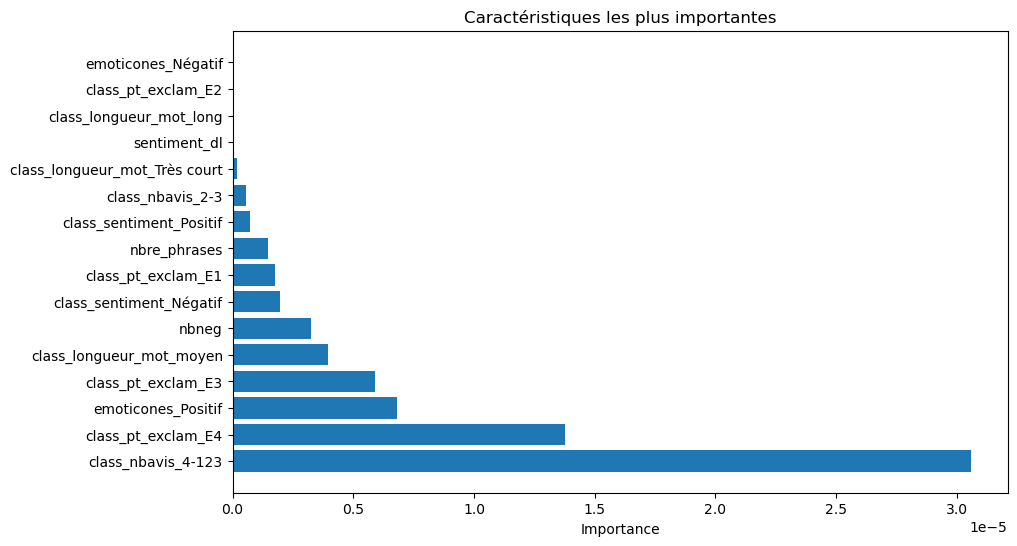

In [13]:
#_________________________Interprétabilité du modele__________________________________

#________________________________shap______________________
# Créer un explainer SHAP
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train_equilibre)

# # Visualiser les valeurs SHAP
# shap.summary_plot(shap_values, X_train_equilibre)

##_______________________________importance des variables_____________________


importances = model.feature_importances_

column_names = X_categorielle_encoded_train.columns.tolist() + X_numerique_train.columns.tolist()

## les noms des caractéristiques
cat_feature_names = X_categorielle_encoded_train.columns  # Pour les caractéristiques catégorielles
num_feature_names = X_numerique_train.columns  # Pour les caractéristiques numériques

# Liste des noms de caractéristiques combinées (uniquement catégorielles et numériques)
combined_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Créer un DataFrame pour l'importance des caractéristiques

selected_importances = importances[:len(combined_feature_names)]

feat_importances = pd.DataFrame({'Feature': combined_feature_names, 'Importance': selected_importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Afficher les 3 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'][:25], feat_importances['Importance'][:25])
plt.xlabel('Importance')
plt.title('Caractéristiques les plus importantes')
plt.show()

In [21]:
# _____________________Optimisation des hyperparamètres avec GridSearchCV pour le modele randomforest____________________
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_equilibre, y_train_equilibre)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Entraînement du modèle optimisé sur les données rééquilibrées
best_model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble de validation
y_val_pred = best_model.predict(X_val_scaled)

# Évaluation du modèle
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Évaluation du modèle
print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))
cmsm = pd.crosstab(y_val, y_val_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\magal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
[[ 154    1    3    5   90]
 [  31    2    3    6   34]
 [  14    1    8   17   96]
 [  12    1    7   49  358]
 [  10    0    3   45 2406]]
              precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      0.10       136
           4       0.40      0.11      0.18       427
           5       0.81      0.98      0.88      2464

    accuracy                           0.78      3356
   macro avg       0.53      0.36      0.37      3356
weighted avg       0.72      0.78      0.73      3356

Classification Report sur l'ensemble de validation:
               precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      

Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,154,1,3,5,90
2,31,2,3,6,34
3,14,1,8,17,96
4,12,1,7,49,358
5,10,0,3,45,2406


----------------------------


In [16]:
#______________________ Validation croisée LightGBM____________________________________________________________

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(random_search, X_train_equilibre, y_train_equilibre, cv=5, scoring='accuracy')

print("Scores de validation croisée : ", cv_scores)
print("Moyenne des scores de validation croisée : ", cv_scores.mean())

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.961461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 343873
[LightGBM] [Info] Number of data points in the train set: 78868, number of used features: 6533
[LightGBM] [Info] Start training from score -1.609413
[LightGBM] [Info] Start training from score -1.609413
[LightGBM] [Info] Start training from score -1.609476
[LightGBM] [Info] Start training from score -1.609413
[LightGBM] [Info] Start training from score -1.609476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [44]:
#########################################- Partie VERIFICATION- ##########################################
##########################################################################################################


# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test2 = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients102 = df.loc[indices_test, 'Note_client'].values
Lemmes102 = df.loc[indices_test, 'Lemmes'].values
nbre_phrases102=df.loc[indices_test, 'nbre_phrases'].values
Lemmes_titre_commentaire102 = df.loc[indices_test, 'Lemmes_titre_commentaire'].values
class_longueur_mot02=df.loc[indices_test, 'class_longueur_mot'].values
class_pt_exclam102 = df.loc[indices_test, 'class_pt_exclam'].values
class_sentiment102 = df.loc[indices_test, 'class_sentiment'].values
emoticones102=df.loc[indices_test, 'emoticones'].values
sentimentfr102 = df.loc[indices_test, 'sentimentfr'].values
sentimentdl102 = df.loc[indices_test, 'sentiment_dl'].values
nbneg102 = df.loc[indices_test, 'nbneg'].values
negatif102 = df.loc[indices_test, 'negatif'].values

 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results102 = pd.DataFrame({
    'Index': indices_test,
    'classe reelle': y_test,
    'Classe prédite': y_test_pred,
    'Note_Client_Original': notes_clients102,
    'Lemmes': Lemmes102,
    'Lemmes_titre_commentaire': Lemmes_titre_commentaire102,
    'Nombre_de_phrases': nbre_phrases102,
    'Classe_longueur_mot': class_longueur_mot02,
    'Classe_pt_exclam': class_pt_exclam102,
    'Classe_sentiment': class_sentiment102,
    'Emoticones': emoticones102,
    'Sentimentfr': sentimentfr102,
    "nombre neg": nbneg102,
    "negatif": negatif102,
    "sentiment":sentimentdl102 
})
# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results102.reset_index(drop=True, inplace=True)

# Affichage des résultats
display(df_test_results102.head())
df_test_results102.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\verifnlp.csv", sep=';', index=False, encoding='utf-8-sig')

#df.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\vverif basee.csv", sep=';', index=False, encoding='utf-8-sig')

,Index,classe reelle,Classe prédite,Note_Client_Original,Lemmes,Lemmes_titre_commentaire,Nombre_de_phrases,Classe_longueur_mot,Classe_pt_exclam,Classe_sentiment,Emoticones,Sentimentfr,nombre neg,negatif,sentiment
0,10324,5,5,5,"['bienréception', 'expéditive']",['bien'],1,Très court,E0,Positif,Neutre,0.010000,0,0,5
1,9382,5,5,5,"['achat', 'imprimante', 'viens', 'recevoir', '...","['achat', 'imprimante', 'viens']",1,moyen,E0,Positif,Neutre,0.376667,0,0,5
2,30764,4,5,4,"['commande', 'sans', 'probl', 'matériel', 'sem...","['commande', 'sans', 'probl']",4,moyen,E0,Positif,Neutre,0.463333,0,0,4
3,33065,4,5,4,"['commande', 'faite', 'fils', 'content']","['nickel', 'rien', 'redire']",2,Court,E0,Positif,Neutre,1.000000,0,0,5
4,15418,4,5,4,"['rien', 'signaler', 'marche', 'bien', 'macbook']","['produit', 'conforme']",2,Court,E0,Neutre,Neutre,0.000000,0,0,5


In [ ]:
#________________________graph des erreurs_________________________________________________


# Analyse des erreurs
errors = pd.DataFrame({'Réel': y_val, 'Prédiction': y_val_pred})
errors['Erreur'] = errors['Réel'] != errors['Prédiction']
error_analysis = errors[errors['Erreur']]

print("Analyse des erreurs :")
print(error_analysis)

# Representation graphique des erreurs
plt.figure(figsize=(10, 6))
sns.countplot(x='Réel', hue='Prédiction', data=error_analysis, palette='Reds')
# Ajouter un fond gris clair
plt.gca().set_facecolor('#f0f0f0')
plt.title("Analyse des erreurs")
plt.xlabel("Classes réelles")
plt.ylabel("Nombre d'erreurs")
plt.legend(title='Prédictions')
plt.show()

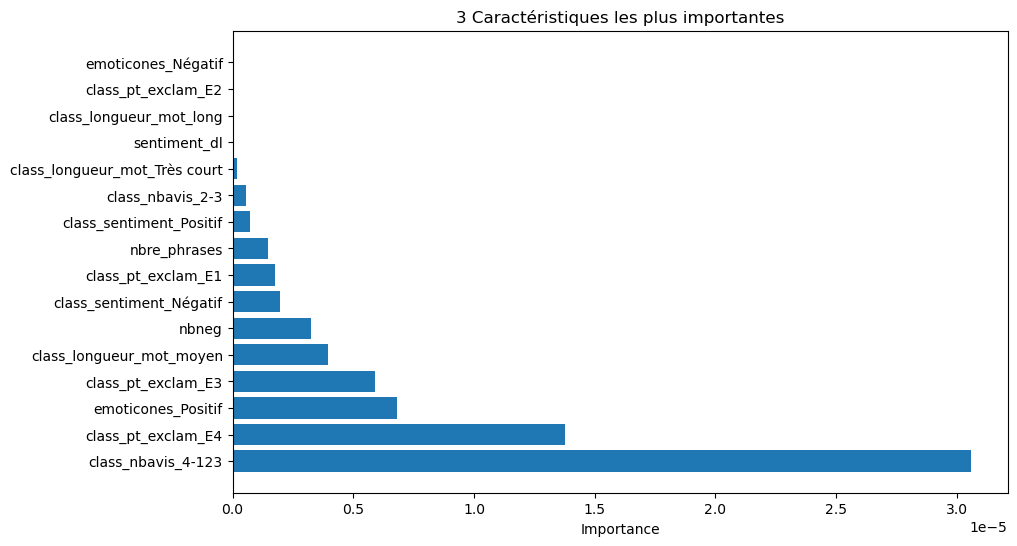

In [ ]:
 # Interprétation des résultats : importance des variables
 # les importances des caractéristiques
importances = model.feature_importances_

column_names = X_categorielle_encoded_train.columns.tolist() + X_numerique_train.columns.tolist()

## les noms des caractéristiques
cat_feature_names = X_categorielle_encoded_train.columns  # Pour les caractéristiques catégorielles
num_feature_names = X_numerique_train.columns  # Pour les caractéristiques numériques

# Liste des noms de caractéristiques combinées (uniquement catégorielles et numériques)
combined_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Créer un DataFrame pour l'importance des caractéristiques

selected_importances = importances[:len(combined_feature_names)]

feat_importances = pd.DataFrame({'Feature': combined_feature_names, 'Importance': selected_importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Afficher les 3 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'][:25], feat_importances['Importance'][:25])
plt.xlabel('Importance')
plt.title('Caractéristiques les plus importantes')
plt.show()

In [15]:
# #Application d'un modèle de classification RandomForestClassifier 
# # cherche les parametre manuellement

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Initialiser le modèle
# #model = RandomForestClassifier(random_state=42)
# model = RandomForestClassifier(n_estimators=50,  # Nombre d'arbres
#                                max_depth=5,     # Profondeur maximale des arbres
#                                min_samples_split=15,  # Nombre minimum d'échantillons requis pour diviser un nœud
#                                min_samples_leaf=10,   # Nombre minimum d'échantillons dans une feuille
#                                random_state=42)

# # Entraînement du modèle
# model.fit(X_train, y_train)

# # Prédictions sur l'ensemble du test
# y_test_pred = model.predict(X_test)

# # Prédictions sur l'ensemble de validation


# # Évaluation du modèle
# print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
# print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
# cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
# display(cmsm)
# print("----------------------------")

# # print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
# # print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))

Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           0       0.61      0.70      0.65      2465
           1       0.72      0.47      0.56      2464
           2       0.60      0.39      0.47      2465
           3       0.54      0.17      0.26      2465
           4       0.42      0.94      0.58      2465

    accuracy                           0.53     12324
   macro avg       0.58      0.53      0.51     12324
weighted avg       0.58      0.53      0.51     12324

Accuracy sur l'ensemble de test: 0.5345666991236612


Classe prédite,0,1,2,3,4
Classe réelle,,,,,
0,1727,155,140,16,427
1,549,1146,209,75,485
2,397,212,973,183,700
3,131,70,286,417,1561
4,27,10,25,78,2325


----------------------------


In [11]:
#analyse des erreurs

# DataFrame avec les valeurs réelles et prédites
results_df = pd.DataFrame({
    'Classe réelle': y_test,
    'Classe prédite': y_test_pred
})

 #Filtrer les erreurs de prédiction
errors_df = results_df[results_df['Classe réelle'] != results_df['Classe prédite']]

# Afficher les lignes avec des erreurs de prédiction
print("Lignes avec des erreurs de prédiction :")
print(errors_df)

# Ajouter une colonne d'index pour pouvoir joindre avec le DataFrame d'origine
errors_df = errors_df.reset_index()

# Joindre avec le DataFrame d'origine en utilisant l'index ou une clé unique
# Assumons que original_df a un index qui correspond à celui de results_df
# Si ce n'est pas le cas, vous devrez utiliser une colonne clé appropriée.
errors_full_df = errors_df.merge(df, left_on='index', right_index=True, suffixes=('_erreur', '_original'))

# Afficher les lignes avec des erreurs de prédiction complétées par les données d'origine
print("Lignes avec des erreurs de prédiction :")
display(errors_full_df)

Lignes avec des erreurs de prédiction :
        Classe réelle  Classe prédite
29962               3               4
120797              3               4
59420               1               0
27283               4               3
103355              3               4
...               ...             ...
17621               3               4
21988               3               4
31018               4               0
29048               4               3
6837                3               4

[308 rows x 2 columns]
Lignes avec des erreurs de prédiction :


,index,Classe réelle,Classe prédite,Nombre_avis_client,Note_client,Lemmes,Lemmes_titre_commentaire,class_nbavis,nbre_mots,nbre_phrases,class_longueur_mot,class_pt_exclam,class_sentiment,emoticones,sentimentfr,Nombre_Émoticônes
0,29962,3,4,8,3,"['contente', 'achat']","['contente', 'achat']",4-123,4,1,Très court,E0,Positif,Neutre,0.650000,0
3,27283,4,3,1,4,"['satisfait', 'seul', 'point', 'negatif', 'pro...",['satisfait'],1,29,2,moyen,E0,Positif,Neutre,0.083333,0
5,8707,3,4,1,3,"['produit', 'conforme', 'commande', 'expédié',...","['délai', 'expédition', 'respecté']",1,12,2,Court,E0,Positif,Neutre,0.100000,0
6,21884,3,4,9,3,"['produits', 'livrés', 'conform', 'conformes',...","['produits', 'livrés', 'conform', 'conformes']",4-123,46,2,long,E0,Positif,Neutre,0.088500,0
8,21358,4,3,3,4,"['colis', 'rapidement', 'martinique', 'petite'...","['colis', 'rapidement', 'martinique']",2-3,35,4,moyen,E0,Positif,Neutre,0.040000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,17621,3,4,1,3,"['vraiment', 'nickel']",['nickel'],1,3,1,Très court,E1,Neutre,Neutre,0.000000,0
304,21988,3,4,2,3,"['satisfaite', 'materiel', 'souci', 'transport...","['satisfaite', 'materiel']",2-3,31,3,moyen,E0,Positif,Neutre,0.480000,0
305,31018,4,0,1,4,"['fonctionné', 'comme', 'prévu', 'retour', 'fa...","['bonne', 'reprise', 'microsoft', 'surface', '...",1,62,2,long,E0,Positif,Neutre,0.098333,0
306,29048,4,3,5,4,"['attractif', 'bien', 'emballé', 'contre', 'po...","['attractif', 'bien', 'emballé']",4-123,29,1,moyen,E0,Positif,Neutre,0.143125,0
